
##  Predicting Land Surface Temperature Using K-nearest-neighbours on Landsat Multispectral Bands (B2–B9)

#### Xihan Yao
#### Department of Geography and the Environment, College of Liberal Arts

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Maria Gonzalez, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

To be completed.
* What is the gap, problem, opportunity, scientific question?

* What was done to address the above?

* What was learned?

* What are your recommendations?

**Guidance**: Write as a single paragraph with 4 or so well-writen sentences.

### Import Packages


In [49]:
%matplotlib inline                                         
suppress_warnings = True
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
import scipy.stats as st                                      # statistical methods
import pandas as pd                                           # DataFrames
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import seaborn as sns                                         # for matrix scatter plots
from sklearn import metrics                                   # measures to check our models
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn.neighbors import KNeighborsRegressor             # for nearest k neighbours
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,KFold) # model tuning
from sklearn.pipeline import (Pipeline,make_pipeline)         # machine learning modeling pipeline
from IPython.display import display, HTML                     # custom displays
cmap = plt.cm.inferno                                         # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                                # grid behind plotting elements
if suppress_warnings == True:  
    import warnings                                           # suppress any warnings for this demonstration
    warnings.filterwarnings('ignore') 
seed = 13                                                     # random number seed for workflow repeatability

### Functions

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_knearest_neighbours.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html). 

In [50]:
def comma_format(x, pos):
    return f'{int(x):,}'

def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal); m = len(pred) + 1
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,axes_commas = True): # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=30, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors="black",zorder=10)
    plt.scatter(xfeature,yfeature,s=60, c='white', marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors=None,zorder=8)
    plt.title(title); plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical'); cbar.set_label(response.name, rotation=270, labelpad=20)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    if axes_commas == True:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    return Z
    
def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, 
                linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours')
    plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(0,np.max(score_mat))
    
def check_model(model,xtrain,ytrain,xtest,ytest,ymin,ymax,rtrain,rtest,title): # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xtrain,ytrain])
    predict_test = model.predict(np.c_[xtest,ytest])
    plt.scatter(rtrain,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Train')
    plt.scatter(rtest,predict_test,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Test')
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(ymin,ymax); plt.ylim(ymin,ymax)
    plt.arrow(ymin,ymin,ymax,ymax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE_train = metrics.mean_squared_error(rtrain,predict_train)
    Var_Explained_train = metrics.explained_variance_score(rtrain,predict_train)
    cor_train = math.sqrt(metrics.r2_score(rtrain,predict_train))
    MSE_test = metrics.mean_squared_error(rtest,predict_test)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.annotate('Train MSE: ' + str(f'{(np.round(MSE_train,2)):,}'),[0.05*(ymax-ymin)+ymin,0.95*(ymax-ymin)+ymin]) 
    plt.annotate('Test MSE:  ' + str(f'{(np.round(MSE_test,2)):,}'),[0.05*(ymax-ymin)+ymin,0.90*(ymax-ymin)+ymin])
    add_grid(); plt.legend(loc='lower right')
    # print('Mean Squared Error on Training = ', round(MSE_test,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

def display_sidebyside(*args):                                # display DataFrames side-by-side (ChatGPT 4.0 generated Spet, 2024)
    html_str = ''
    for df in args:
        html_str += df.head().to_html()  # Using .head() for the first few rows
    display(HTML(f'<div style="display: flex;">{html_str}</div>'))

### Load Data

The following workflow uses the .csv file “LST_samples_with_bands_and_indices.csv”, a synthetic dataset generated by Xihan Yao from Landsat imagery near Austin, TX. All images were acquired by the same Landsat satellite during Summer 2025. Landsat data are publicly available and can be accessed through multiple platforms. A brief explanation of how this dataset was generated is provided below.

This dataset is synthetic. I generated it using the Land Surface Temperature (LST) layer from Landsat 8 as the underlying source. A total of 1,000 samples were collected. The first 500 samples were drawn completely at random, while the remaining 500 were intentionally sampled near temperature “hotspots,” identified based on the highest values among the initial 500 points.

Because of the urban heat island effect, urbanized areas are typically warmer than their surrounding rural environments. This pattern is reflected in Austin, where the city center exhibits higher surface temperatures than its peripheral regions. I assume that more people reside in these urbanized zones, leading to greater participation in citizen science activities and increased data collection from their homes. This results in higher sampling density in urban areas.

Consequently, the final sample distribution is not entirely spatially random. Additionally, no samples were taken over water bodies.

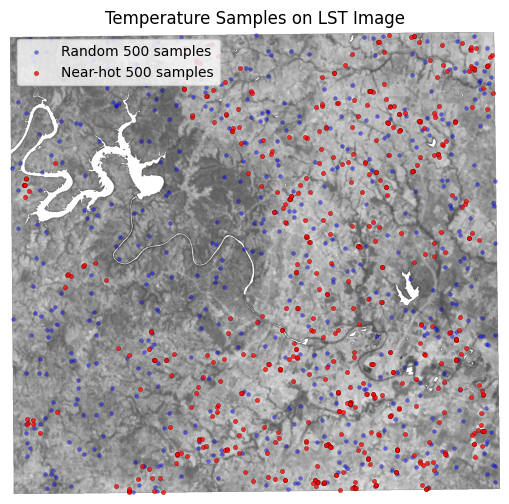

Following this sampling step, I extracted the corresponding values of Landsat Bands 2 through 9 at each sample location and calculated several vegetation indices. From this point forward, our analysis is based solely on the resulting tabular dataset. The remote sensing images are used only as the initial source for data extraction and will not be directly involved in the subsequent workflow.

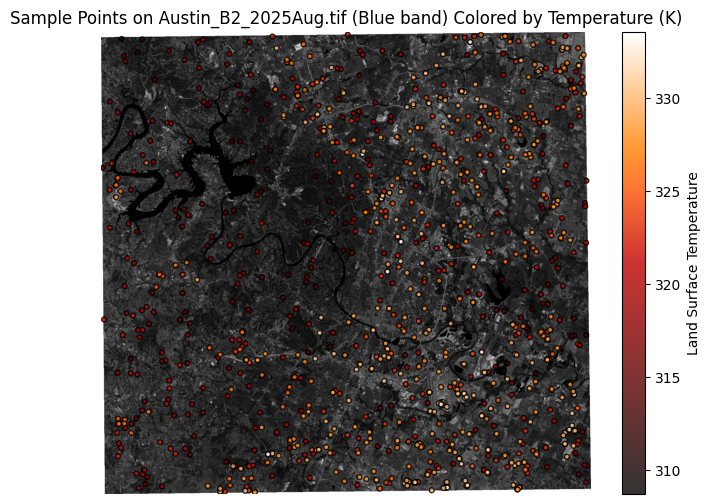


We will work with the following features:

* **Land Surface Temperature (LST)** – a measurement of the Earth’s surface temperature derived from thermal infrared radiation. Not the same as air temperature, but used here as a proxy for near-surface air temperature.

* **X_coor** – X coordinate of the sample (column position).
* **Y_coor** – Y coordinate of the sample (row position).

* **B2 Blue** – reflectance of blue light in the electromagnetic spectrum.
* **B3 Green** – reflectance of green light in the electromagnetic spectrum.
* **B4 Red** – reflectance of red light, important for vegetation analysis.
* **B5 NIR** – reflectance of near-infrared energy, strongly responsive to healthy vegetation.
* **B6 SWIR1** – reflectance in the shortwave infrared region, sensitive to soil and vegetation moisture.
* **B7 SWIR2** – reflectance in the deeper shortwave infrared region, useful for detecting burned or dry surfaces.
* **B8 Panchromatic** – high-resolution grayscale band used for pan-sharpening.
* **B9 Cirrus** – reflectance used to detect high-altitude thin cirrus clouds.

* **NDVI** – Normalized Difference Vegetation Index; measures vegetation greenness using NIR and Red reflectance. (B5 - B4) / (B5 + B4)
* **EVI** – Enhanced Vegetation Index; improves vegetation sensitivity by reducing atmospheric and canopy background effects. 2.5 * (B5 - B4) / (B5 + 6*B4 - 7.5*B2 + 1)
* **NDWI** – Normalized Difference Water Index; highlights open water and vegetation moisture using Green and NIR reflectance. (B3 - B5) / (B3 + B5)

Load data and do some column renaming

In [109]:
url = "https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/main/LST_samples_with_bands_and_indices.csv"
df = pd.read_csv(url)
df = df.rename(columns={'row':'Y_coor', 'col':'X_coor', 'x':'source_x', 'y':'source_y'})

Check the last 5 inputs of the data. X_coor and Y_coor are the relative geographic coordinates of the sample points within the study scope.
Since geographic projection system is not an important part of this study. I will drop the real x y coordinates and use the relative coordinates to represent geographic information in this study

In [110]:
df.tail(5)

,Y_coor,X_coor,source_x,source_y,land surface temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI
995,1451,1724,642825.0,3337155.0,330.284943,0.257346,0.229267,0.253368,0.466649,0.543651,0.375880,0.105432,0.001045,0.296217,0.504562,-0.341107
996,507,1465,635055.0,3365475.0,331.696594,0.279925,0.289051,0.207447,0.397914,0.238178,0.153747,0.113968,0.001312,0.314634,0.876666,-0.158470
997,1624,545,607455.0,3331965.0,326.983124,0.293555,0.280335,0.291098,0.725909,0.496580,0.272808,0.113901,0.001134,0.427539,0.855364,-0.442809
998,507,1464,635025.0,3365475.0,330.643829,0.288759,0.290279,0.219615,0.430146,0.226244,0.146220,0.116658,0.001111,0.324014,0.904119,-0.194145
999,475,1293,629895.0,3366435.0,328.046143,0.419149,0.429854,0.450620,0.699234,0.453253,0.328420,0.182767,0.001200,0.216213,0.493539,-0.238582


data summary

In [111]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Y_coor,1000.0,9.130640e+02,508.584870,9.000000e+00,4.437500e+02,9.840000e+02,1.379250e+03,1.675000e+03
X_coor,1000.0,1.046873e+03,476.403979,5.000000e+00,7.140000e+02,1.135000e+03,1.423250e+03,1.767000e+03
source_x,1000.0,6.225112e+05,14292.119383,5.912550e+05,6.125250e+05,6.251550e+05,6.338025e+05,6.441150e+05
source_y,1000.0,3.353293e+06,15257.546114,3.330435e+06,3.339308e+06,3.351165e+06,3.367372e+06,3.380415e+06
land surface temperature,1000.0,3.244896e+02,5.158484,3.087172e+02,3.203334e+02,3.260449e+02,3.287972e+02,3.335731e+02
B2_blue,1000.0,3.050707e-01,0.095092,1.925305e-01,2.480444e-01,2.821776e-01,3.273521e-01,8.255881e-01
B3_green,1000.0,2.881425e-01,0.114909,1.407019e-01,2.196440e-01,2.631660e-01,3.172467e-01,9.398332e-01
B4_red,1000.0,2.942912e-01,0.148455,8.161966e-02,1.965229e-01,2.651256e-01,3.587213e-01,1.000000e+00
B5_NIR,1000.0,6.548376e-01,0.148721,1.388300e-01,5.664451e-01,6.525531e-01,7.432969e-01,1.000000e+00
B6_SWIR1,1000.0,4.149953e-01,0.153381,0.000000e+00,2.981571e-01,3.985189e-01,5.358705e-01,9.388192e-01


The response feature in this study is "land surface temperature". The predictors are the 8 spectral bands, 3 indices, and the x y coordinates.

In [112]:
response = 'land surface temperature'   # response (y)

np.random.seed(seed=seed)               # random seed

# 2. Select predictors and response
# Drop response + source coordinate columns from predictors
X = df.drop(columns=[response, 'source_x', 'source_y'])
y = df[response]

# Predictor and response labels
pred = X.columns.tolist()
resp = [response]

# Rebuild df as predictors + response
df = pd.concat([X, y], axis=1)

# 3. Feature names for plotting
featurelabel = pred + resp
featuretitle = featurelabel

resplabel = 'Land Surface Temperature (K)'

# 4. Plot ranges (auto from data)
Xmin = X.min().tolist()
Xmax = X.max().tolist()
ymin = y.min()
ymax = y.max()

m = len(pred) + 1     # number of predictors + response
mpred = len(pred)      # number of predictors

print("Predictors:", pred)
print("Response:", response)
print(df.head())

Predictors: ['Y_coor', 'X_coor', 'B2_blue', 'B3_green', 'B4_red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2', 'B8_pan', 'B9_cirrus', 'NDVI', 'EVI', 'NDWI']
Response: land surface temperature
   Y_coor  X_coor   B2_blue  B3_green    B4_red    B5_NIR  B6_SWIR1  B7_SWIR2  \
0     264     603  0.208734  0.162112  0.113091  0.517424  0.205107  0.084564   
1     725     924  0.265945  0.214233  0.190425  0.549656  0.237788  0.134326   
2     775     467  0.218445  0.180773  0.138421  0.593588  0.190990  0.079884   
3    1014     538  0.281388  0.253192  0.241259  0.733513  0.437381  0.244457   
4      37     539  0.225347  0.200311  0.157725  0.738252  0.312352  0.136666   

     B8_pan  B9_cirrus      NDVI       EVI      NDWI  land surface temperature  
0  0.077290   0.001134  0.641274  1.603315 -0.522875                 314.24417  
1  0.083514   0.001223  0.485395  1.287348 -0.439099                 320.11633  
2  0.107544   0.001111  0.621806  1.448148 -0.533105                 320.67004  
3  0.103

Before running any models, let us do some Exploratory data analysis. First check if there are any intercorrelations. And then check the correlation of each features with land surface temperature.
It is reasonable that X_coor and Y_coor do not have any correlation with any other features. Some others, though, are highly correlated. e.g. NDVI and EVI are correlated. This is because these to indices are comparable and are both used for representing the abundance of vegetation. 

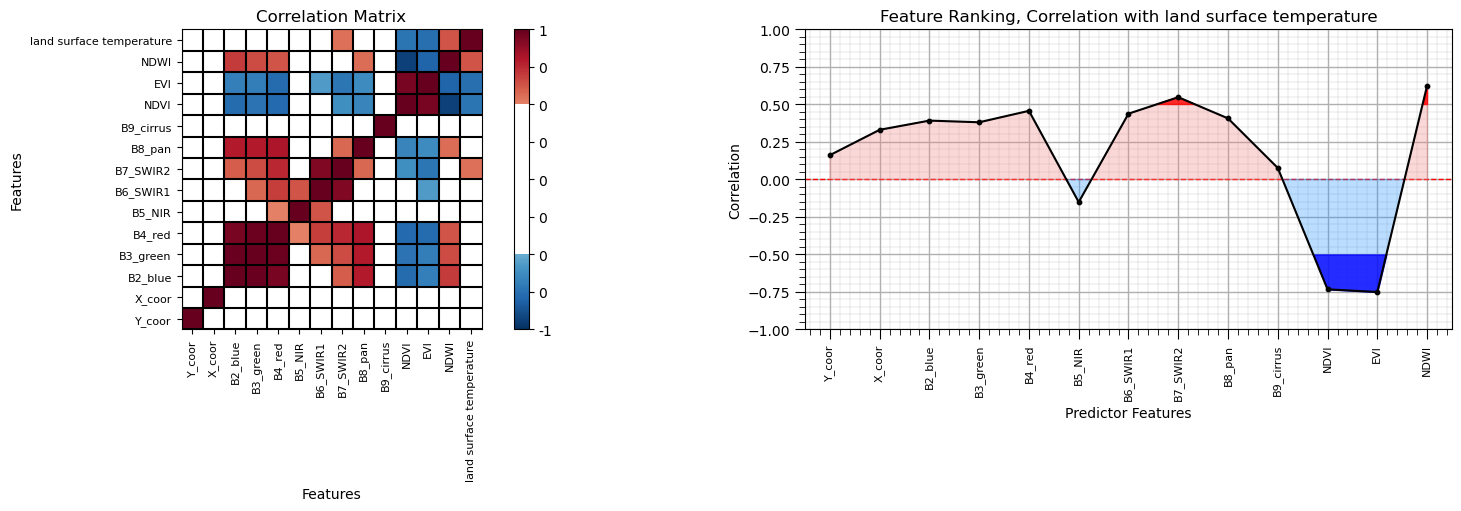

In [113]:
# Subset df to predictors + response
df_corr = df[pred + resp]

# Correlation matrix
corr_matrix = df_corr.corr()

# Correlation of predictors with response
correlation = corr_matrix[response].loc[pred].values

plt.figure(figsize=(16, 5))

# ---- Left plot: correlation matrix ----
plt.subplot(121)
plot_corr(corr_matrix, 'Correlation Matrix', 1.0, 0.5)
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# ---- Right plot: correlation ranking ----
plt.subplot(122)
feature_rank_plot(pred, correlation, -1.0, 1.0, 0.0,
                  'Feature Ranking, Correlation with ' + resp[0],
                  'Correlation', 0.5)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Correlation")

# Adjust layout
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.98, top=0.85,
                    wspace=0.3, hspace=0.3)

plt.show()

### Step 1: Bench mark model, predict LST using geographic X Y coordinates only

First model we will use X and Y coordinates only as predictors. X and Y bring the reletive geographic context.
According to Tobler's first law of geography, "everything is related to everything else, but near things are more related than distant things." If two measure points are close enough, their recorded temperature should be close enough as well.
To begin, we will standardize the X and Y coordinates

In [114]:
# Select X and Y coordinate features
coord_features = ['X_coor', 'Y_coor']

# Standardized column names
std_cols = ['sX', 'sY']

# Standardize X and Y
scaler = StandardScaler()
df[std_cols] = scaler.fit_transform(df[coord_features])

# Output
print("Selected Predictor Features:", coord_features)
print("Standardized Feature Names:", std_cols)
print("Response Feature:", response)
df.head()


Selected Predictor Features: ['X_coor', 'Y_coor']
Standardized Feature Names: ['sX', 'sY']
Response Feature: land surface temperature


,Y_coor,X_coor,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI,land surface temperature,sX,sY
0,264,603,0.208734,0.162112,0.113091,0.517424,0.205107,0.084564,0.077290,0.001134,0.641274,1.603315,-0.522875,314.24417,-0.932182,-1.276854
1,725,924,0.265945,0.214233,0.190425,0.549656,0.237788,0.134326,0.083514,0.001223,0.485395,1.287348,-0.439099,320.11633,-0.258047,-0.369964
2,775,467,0.218445,0.180773,0.138421,0.593588,0.190990,0.079884,0.107544,0.001111,0.621806,1.448148,-0.533105,320.67004,-1.217797,-0.271603
3,1014,538,0.281388,0.253192,0.241259,0.733513,0.437381,0.244457,0.103609,0.001111,0.504995,1.149422,-0.486793,319.97960,-1.068689,0.198564
4,37,539,0.225347,0.200311,0.157725,0.738252,0.312352,0.136666,0.095118,0.001267,0.647927,1.459354,-0.573154,317.55966,-1.066589,-1.723414


Then we will do train-test split

In [115]:
# Train–test split using the standardized X and Y predictors
X_train, X_test, y_train, y_test = train_test_split(
    df[['sX', 'sY']], df[[response]], 
    test_size=0.25, random_state=73073
)

# Recombine predictors + response
df_train = pd.concat([X_train, y_train], axis=1)
df_test  = pd.concat([X_test, y_test], axis=1)

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_knearest_neighbours.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html). 
After we did the train-test split, let's visualize and compare them.
As you can see, this dataset is not competely random. The distribution of LST is not a normal distribution

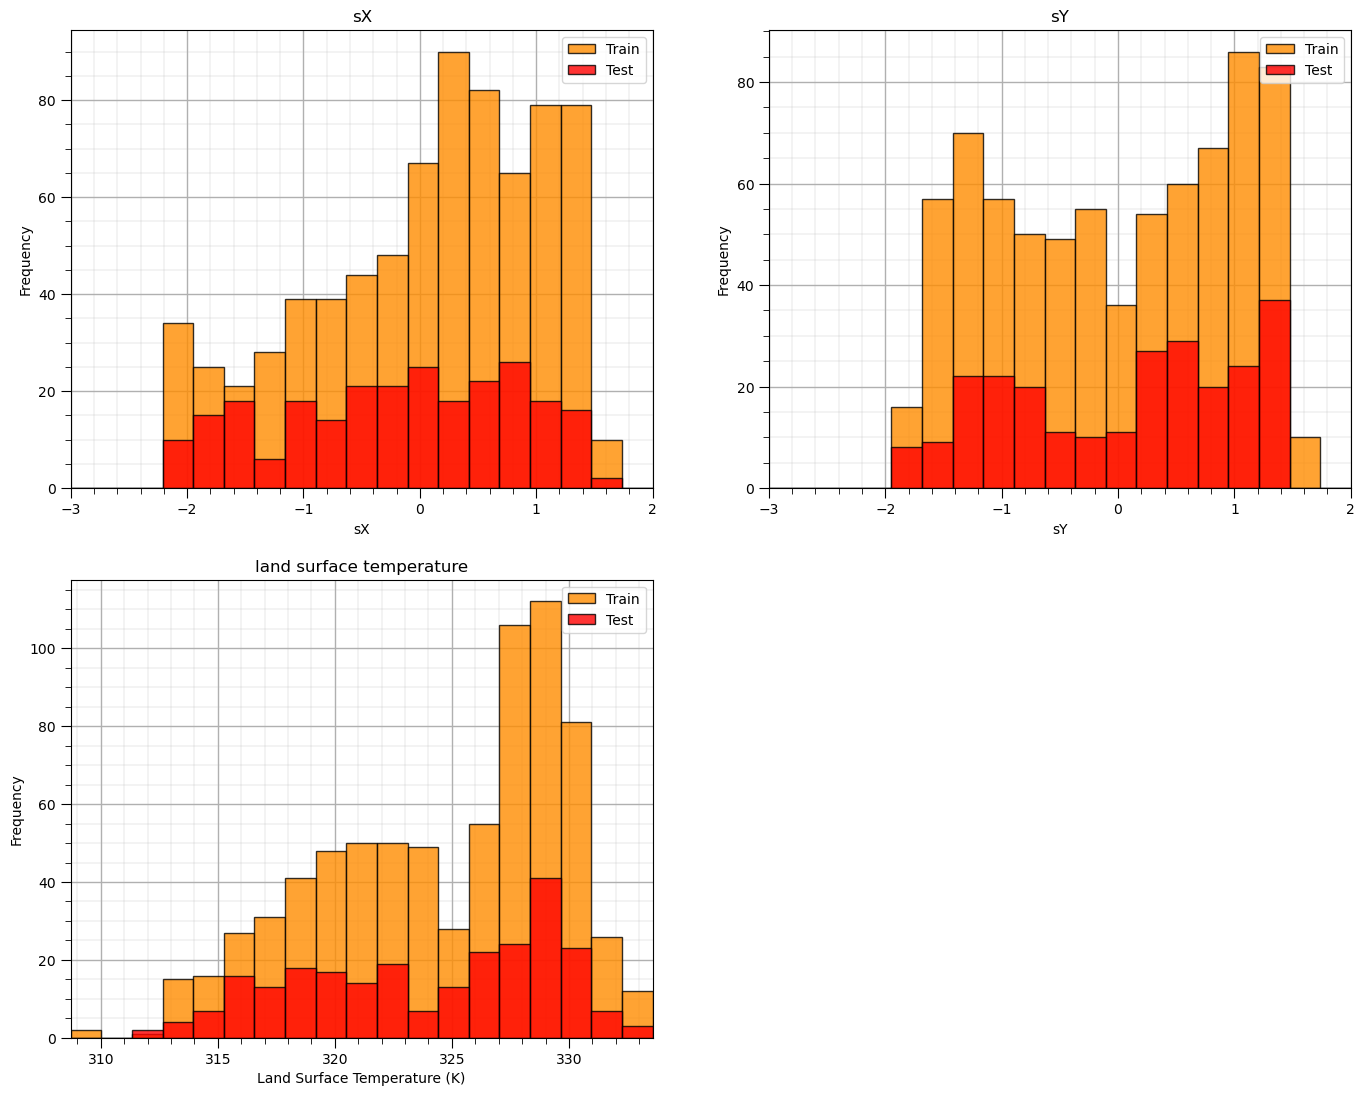

In [132]:
# Compute limits from standardized columns
sxmin, sxmax = df[std_cols[0]].min(), df[std_cols[0]].max()
symin_, symax_ = df[std_cols[1]].min(), df[std_cols[1]].max()

nbins = 20                                                    # number of histogram bins

plt.subplot(221)
plt.hist(X_train[std_cols[0]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[0]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[0]); plt.xlim(-3,2); plt.xlabel(std_cols[0]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(222)
plt.hist(X_train[std_cols[1]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[1]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[1]); plt.xlim(-3,2); plt.xlabel(std_cols[1]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(223)
plt.hist(y_train[resp],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Train')
plt.hist(y_test[resp],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Test')
plt.legend(loc='upper right'); plt.title(resp[0]); plt.xlim(ymin,ymax) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlabel(resplabel); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Let's visualize the X and Y values of sample points and their temperature. You can read this as a map. 
For your reference, here is the real temperature map. You can see download Austin on East side of this map.
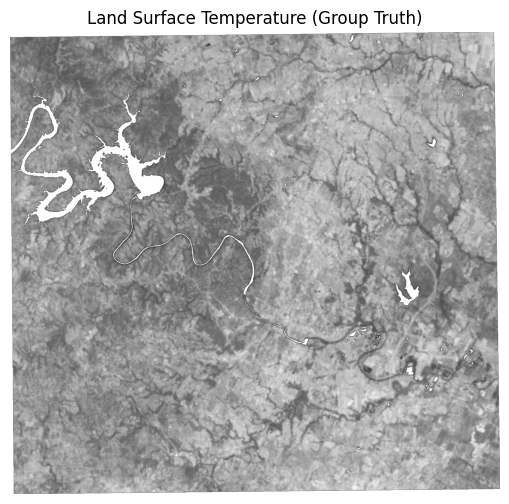

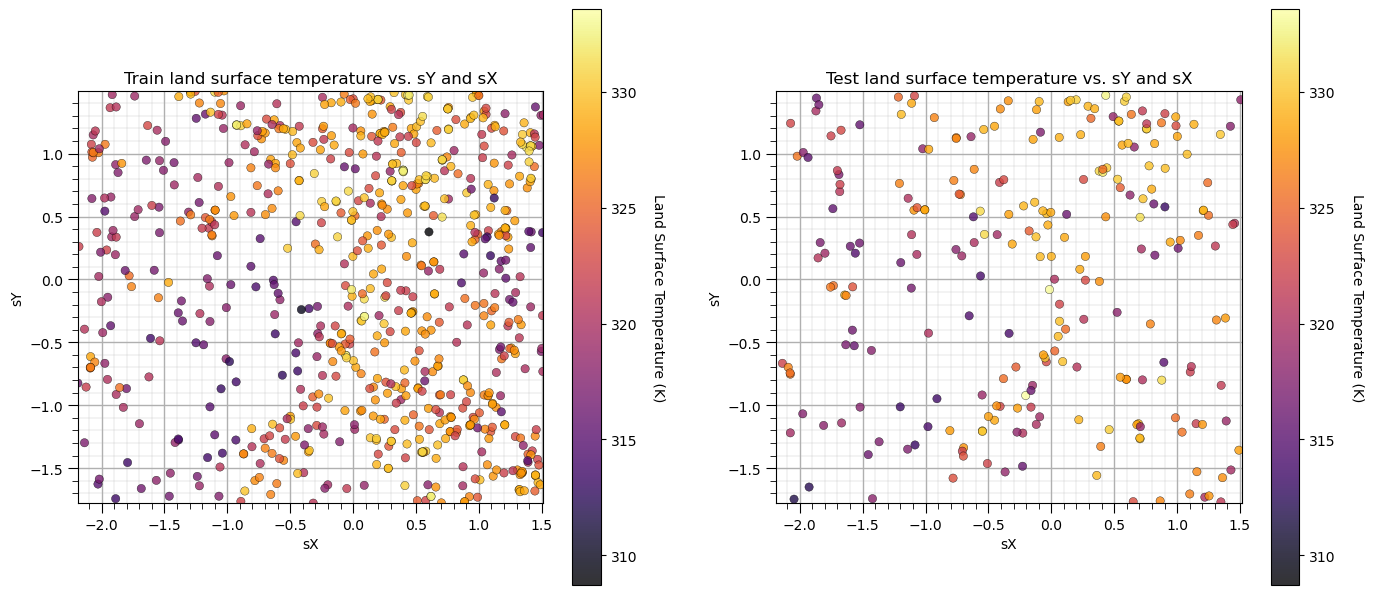

In [135]:


plt.subplot(121)                                              # train data plot
im = plt.scatter(X_train[std_cols[0]],X_train[std_cols[1]],s=None, c=y_train[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Train ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplot(122)                                               # test data plot
im = plt.scatter(X_test[std_cols[0]],X_test[std_cols[1]],s=None, c=y_test[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Test ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Here we set up important KNN hyperparameters.
Since we have plenty of samples, I will let it consider n_neighbours. P = 2 for Euclidean distance. 
Weight is "distance". Which mean, the closer to the point, the more influence.

In [149]:
n_neighbours = 10; p = 2; weights = 'distance'                # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model

Here we visualize the results for the first X Y only KNN model for temperature prediction. The result is interesting. With just X Y values we can achieve a pretty reasonable prediction results.

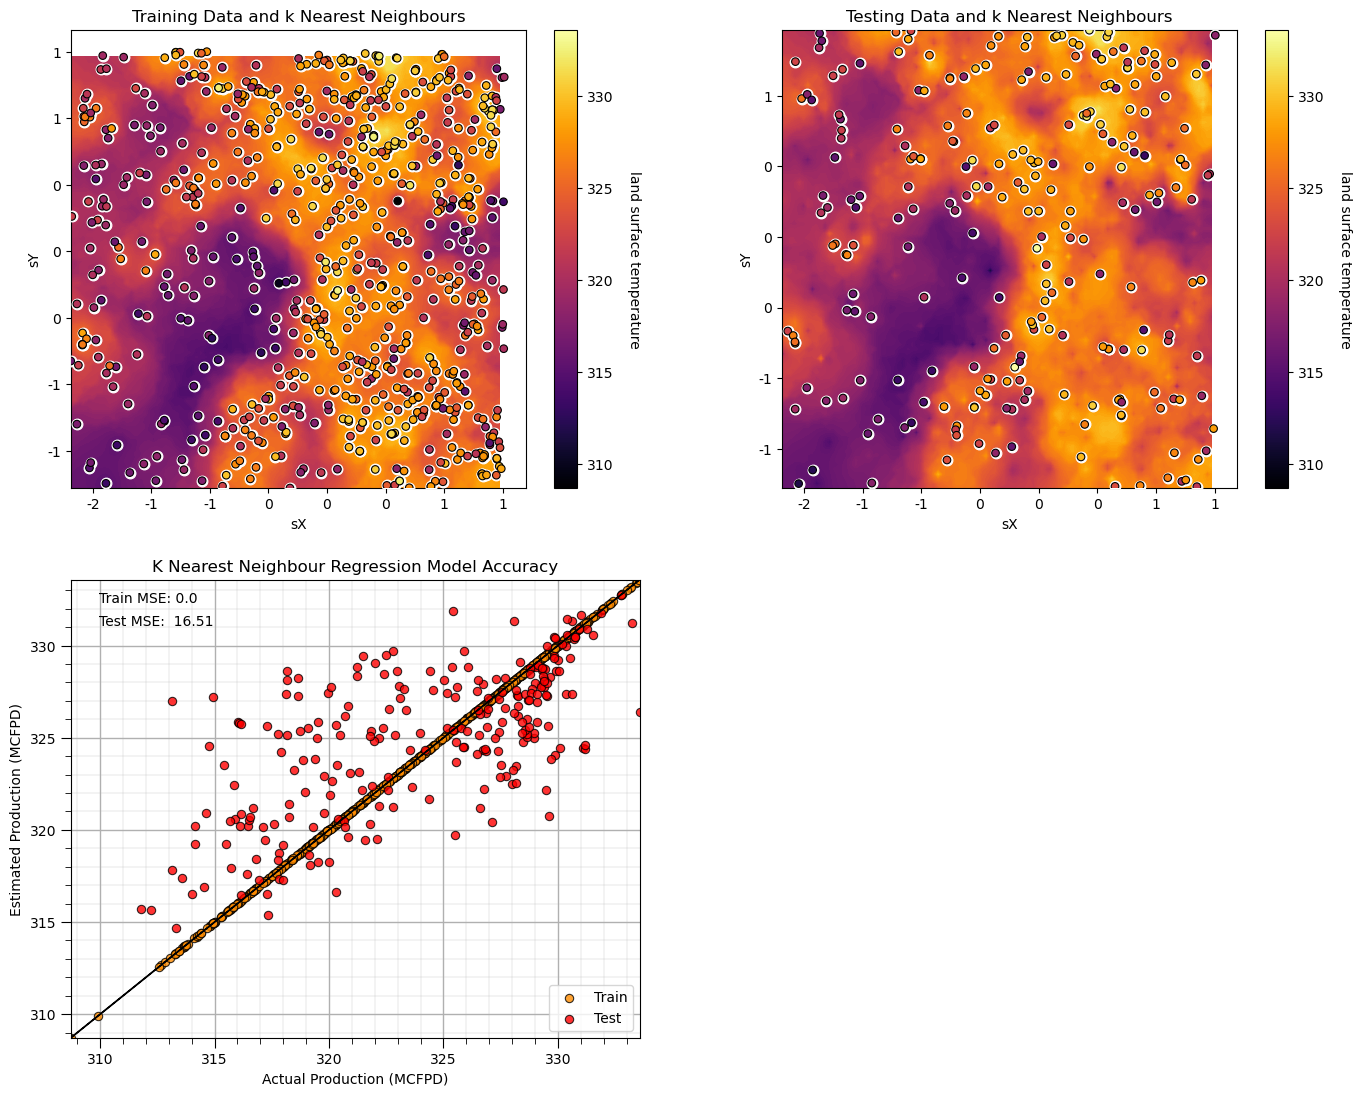

In [150]:
neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(221)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[std_cols[0]],sxmin,sxmax,X_train[std_cols[1]],symin_,symax_,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(222)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[std_cols[0]],sxmin,sxmax,X_test[std_cols[1]],symin_,symax_,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(223)                                              # model accuracy check
check_model(neigh_fit,X_train[std_cols[0]],X_train[std_cols[1]],X_test[std_cols[0]],X_test[std_cols[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.25, hspace=0.2); plt.show()

Here, we will do an experiment to get the most reasonable k value. 

In [147]:
k = 1                                                         # set initial, lowest k hyperparameter
dist_error = []; unif_error = []; k_mat = []                  # make lists to store the results
while k <= 100:                                               # loop over the k hyperparameter
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 2) # instantiate the model
    neigh_dist_fit = neigh_dist.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    dist_error.append(MSE)                                    # add to the list of MSE
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 2)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    unif_error.append(MSE)                                    # add to the list of MSE
    
    k_mat.append(k)                                           # append k to an array for plotting
    k = k + 1

We plot the relationship between MSE and K. When K is around 10, the MSE reaches its min. 

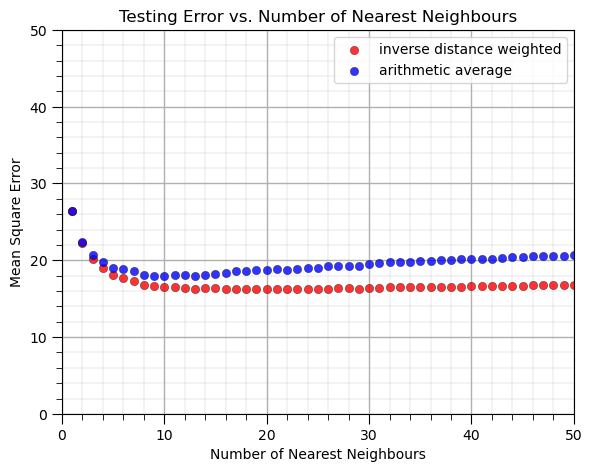

In [148]:
plt.subplot(111)
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend(); add_grid()
plt.xlim(0,50); plt.ylim([0,50])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8,wspace=0.15,hspace=0.2); plt.show()

This is the integrated workflow. I will leave it here for now.

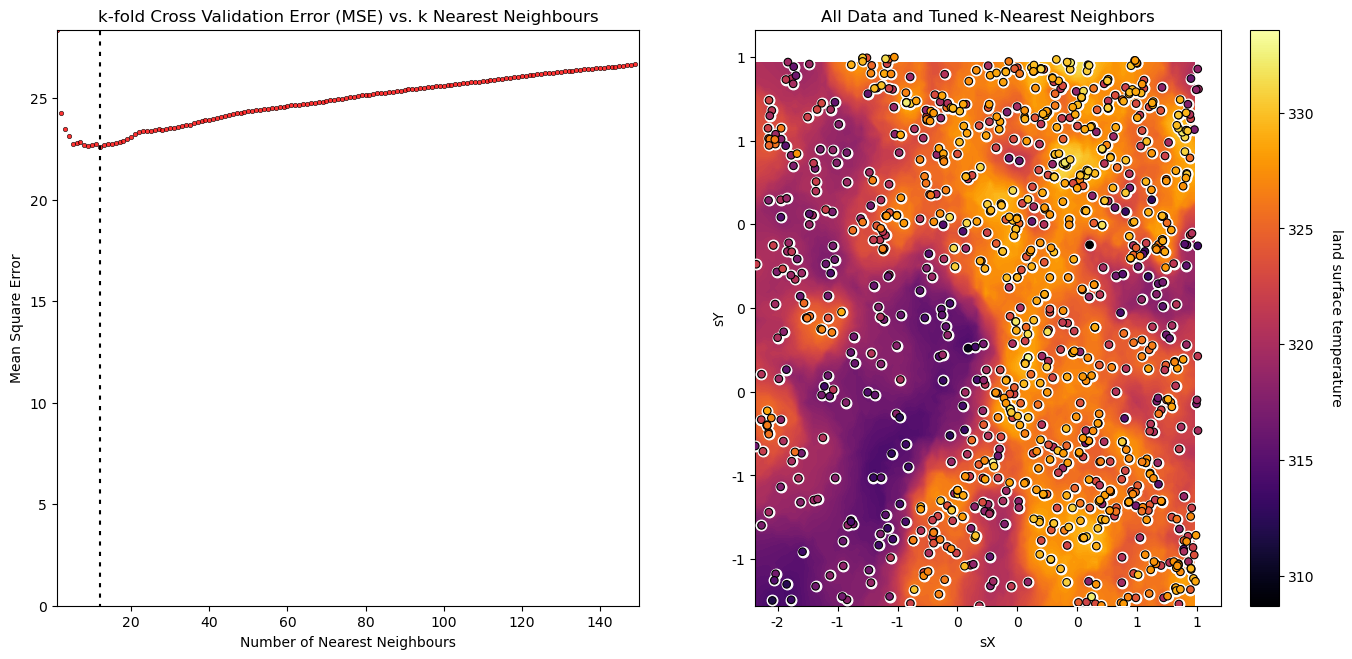

In [158]:
# In a combined workflow
# ------------------------------------------------------------
# Setup
# ------------------------------------------------------------
folds = 4
k_min = 1
k_max = 150

# Predictors: standardized X and Y
X_pipe = df[['sX', 'sY']]

# Response
y_pipe = df[response]   # remains 1D Series

# Machine learning pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

# Hyperparameter search space
params = {
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min, k_max, 1, dtype=int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],              # p=2 → Euclidean
    'knear__weights': ['distance']
}

# Grid search cross-validation
grid_cv_tuned = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=folds, shuffle=False),
    refit=True
)

# Fit the tuned model
grid_cv_tuned.fit(X_pipe, y_pipe)

# ------------------------------------------------------------
# Visualizations
# ------------------------------------------------------------
plt.subplot(121)
visualize_tuned_model(
    grid_cv_tuned.best_params_['knear__n_neighbors'],
    grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
    abs(grid_cv_tuned.cv_results_['mean_test_score'])
)

plt.subplot(122)
visualize_model(
    grid_cv_tuned,
    df['sX'], df['sX'].min(), df['sX'].max(),
    df['sY'], df['sY'].min(), df['sY'].max(),
    df[response], df[response].min(), df[response].max(),
    'All Data and Tuned k-Nearest Neighbors'
)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2,
                    wspace=0.2, hspace=0.2)
plt.show()


### Step 2: predict LST using spectural and vegetation indicies data.

There is scienctific evidence that land surface temperature is affected by local environments, including land use and land cover. This information is detectable through remote sensing, including satellite images. Optical sensors are the most common sensers on satellites in the space, whereas temperature sensors are rarer. Landsat satellites are equited with both optical spectural sensors and temperature sensors. This goal of this step is to build a model to predict LST from spectural information

First of all let's standardize the features. 
For B2 to B9, the numbers are representing the reflectence of certain electromegnative wave length. so by nature the value range from 0 - 1
For NDVI and NDWI, N stands for "normalized", so they are already normalized
Even though, we still run the standardization code.

In [160]:
# Select X and Y coordinate features
coord_features = ['B2_blue', 'B3_green', 'B4_red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2', 'B8_pan', 'B9_cirrus', 'NDVI', 'EVI', 'NDWI']

# Standardized column names
std_cols = ['sB2', 'sB3', 'sB4', 'sB5', 'sB6', 'sB7', 'sB8', 'sB9', 'sNDVI', 'sEVI', 'sNDWI']

# Standardize X and Y
scaler = StandardScaler()
df[std_cols] = scaler.fit_transform(df[coord_features])

# Output
print("Selected Predictor Features:", coord_features)
print("Standardized Feature Names:", std_cols)
print("Response Feature:", response)
df.head()


Selected Predictor Features: ['B2_blue', 'B3_green', 'B4_red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2', 'B8_pan', 'B9_cirrus', 'NDVI', 'EVI', 'NDWI']
Standardized Feature Names: ['sB2', 'sB3', 'sB4', 'sB5', 'sB6', 'sB7', 'sB8', 'sB9', 'sNDVI', 'sEVI', 'sNDWI']
Response Feature: land surface temperature


,Y_coor,X_coor,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,...,sB3,sB4,sB5,sB6,sB7,sB8,sB9,sNDVI,sEVI,sNDWI
0,264,603,0.208734,0.162112,0.113091,0.517424,0.205107,0.084564,0.077290,0.001134,...,-1.097333,-1.221185,-0.924430,-1.369092,-1.389684,-1.007096,-0.341507,1.407047,1.666894,-0.929351
1,725,924,0.265945,0.214233,0.190425,0.549656,0.237788,0.134326,0.083514,0.001223,...,-0.643521,-0.700002,-0.707594,-1.155918,-0.960829,-0.885280,0.113532,0.504227,0.944543,-0.328582
2,775,467,0.218445,0.180773,0.138421,0.593588,0.190990,0.079884,0.107544,0.001111,...,-0.934857,-1.050480,-0.412051,-1.461179,-1.430015,-0.414984,-0.455267,1.294294,1.312157,-1.002713
3,1014,538,0.281388,0.253192,0.241259,0.733513,0.437381,0.244457,0.103609,0.001111,...,-0.304308,-0.357409,0.529281,0.146018,-0.011703,-0.491989,-0.455267,0.617742,0.629221,-0.670600
4,37,539,0.225347,0.200311,0.157725,0.738252,0.312352,0.136666,0.095118,0.001267,...,-0.764741,-0.920381,0.561157,-0.669536,-0.940664,-0.658181,0.341052,1.445580,1.337776,-1.289915


In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    df[std_cols],
    df[response],
    test_size=0.25,
    random_state=73073
)

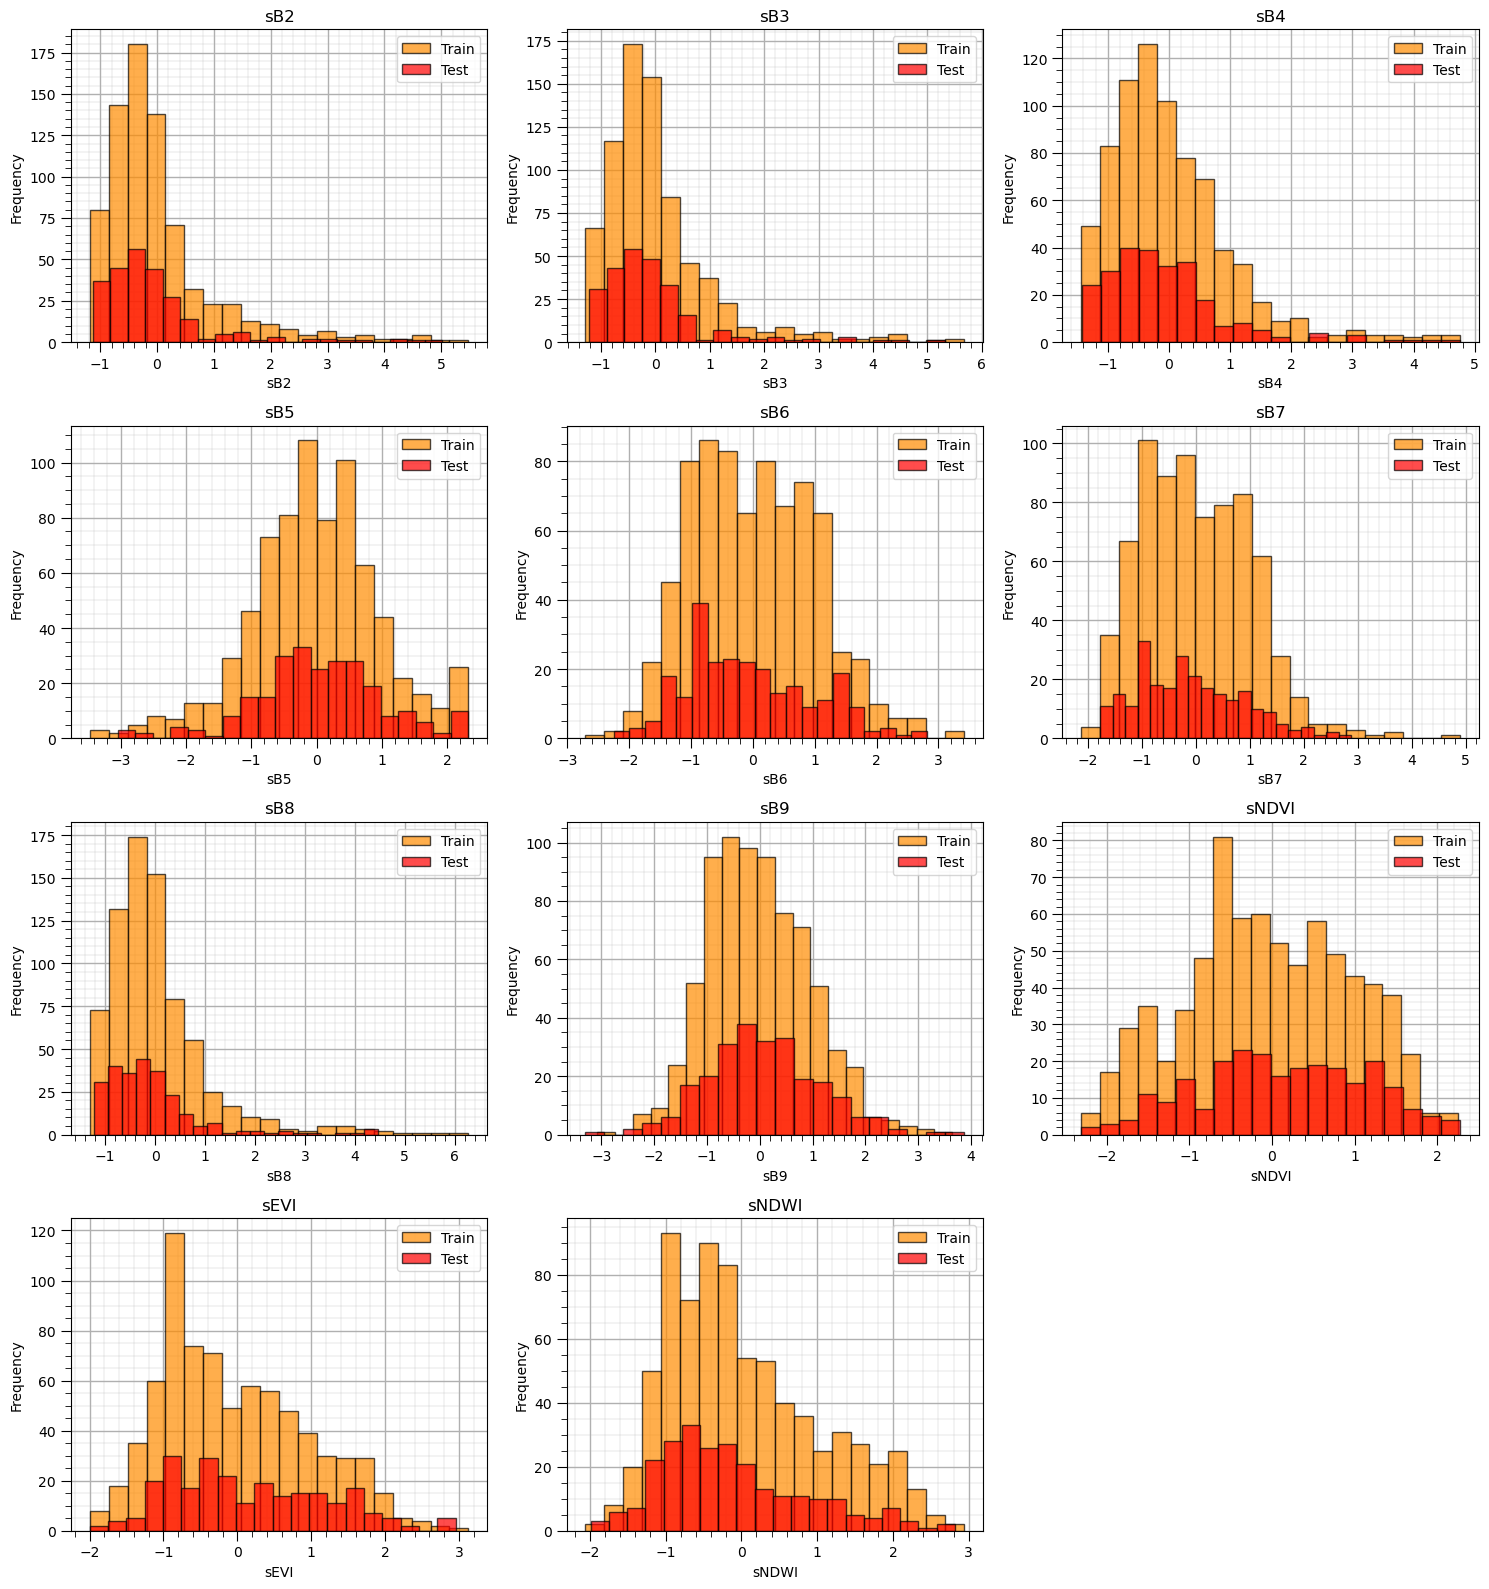

In [165]:
nbins = 20
n_features = len(std_cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(15, 4 * n_rows))

for i, feature in enumerate(std_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    # Histogram for train data
    plt.hist(
        X_train[feature], bins=nbins, alpha=0.7,
        color='darkorange', edgecolor='black', label='Train'
    )

    # Histogram for test data
    plt.hist(
        X_test[feature], bins=nbins, alpha=0.7,
        color='red', edgecolor='black', label='Test'
    )

    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    add_grid()

plt.tight_layout()
plt.show()

In [168]:
n_neighbours = 10; p = 2; weights = 'distance'                # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

Because there are now 11 features. We can not easily plot them using maps. Here I am thinking of some ways to show case the importance of each features. And the overall performance of the model. And of course, I am aware of the curse of dimensionality.

The MSE is now much lower than the X Y model.

In [176]:
from sklearn.metrics import mean_squared_error

# Predict on test data
y_pred_test = neigh_fit.predict(X_test)

# Compute MSE
mse_test = mean_squared_error(y_test, y_pred_test)

print("Test MSE:", mse_test)


Test MSE: 7.051394397822895


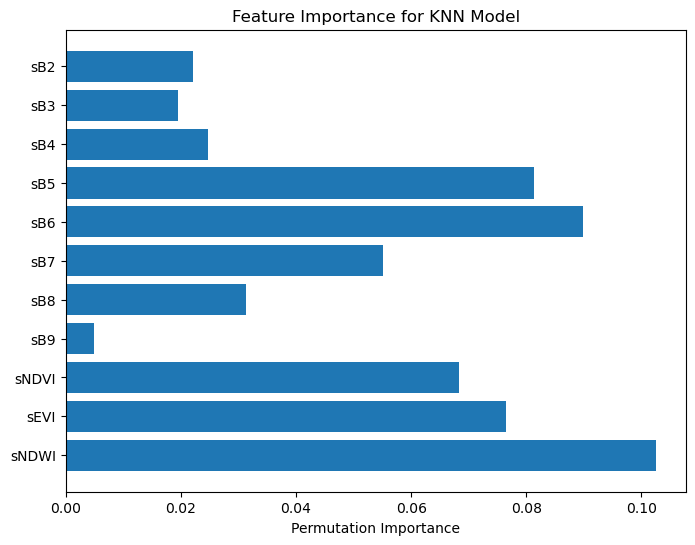

In [169]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    neigh_fit, X_test, y_test, n_repeats=10, random_state=0
)

importances = result.importances_mean

plt.figure(figsize=(8,6))
plt.barh(std_cols, importances)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for KNN Model")
plt.gca().invert_yaxis()
plt.show()


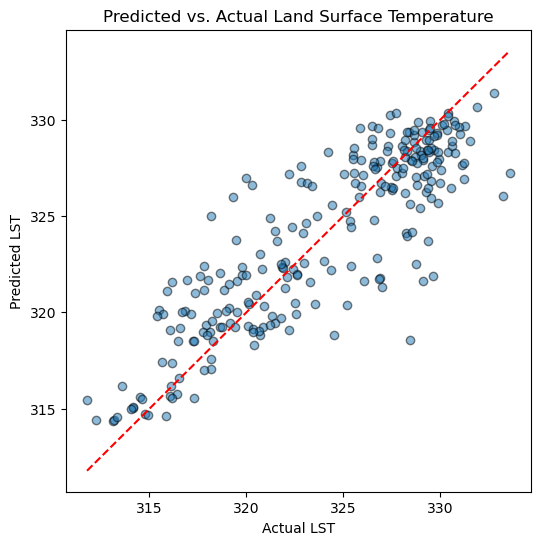

In [173]:
y_pred = neigh_fit.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor="black")
plt.xlabel("Actual LST")
plt.ylabel("Predicted LST")
plt.title("Predicted vs. Actual Land Surface Temperature")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.show()


### Name of My Workflow

A short summary of your workflow. This is a suggestion. The main thing is to be clear and concise. Easy to follow!

1. If helpful, you could include

2. enumeration

### 1. Name Your First Workflow Step

This is a short summary of this step.

Short Markdown block, code, concise and essential output summaries, repeat  

### 2. Name Your Second Workflow Step

Repeat as needed

### Results

Final summary of results, include table (DataFrame) and / plots, answer the problem and demonstrate the work stated in the executive summary.

### Parting Comments / Promote You

Consider adding any information to promote your capabilities, interest in internships, full-time positions. 

* This workflow will be shared / posted online and will promote you. 

* It is optional to retain my information below yours. This may also provide some ideas.


#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)